In [ ]:

# # Data import and basic exploration


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None


app = pd.read_csv(r"application_data.csv")

msng_info = pd.DataFrame(app.isnull().sum().sort_values()).reset_index()
msng_info.rename(columns={'index':'col_name',0:'null_count'},inplace=True)
msng_info.head()

msng_info['msng_pct'] = msng_info['null_count']/app.shape[0]*100

# msng_info.to_excel(r"D:\Learnerea\Tables\loan_default_data\missing_info.xlsx",index=False)

msng_info.head()

msng_col = msng_info[msng_info['msng_pct']>=40]['col_name'].to_list()
app_msng_rmvd = app.drop(labels=msng_col,axis=1)
app_msng_rmvd.shape

app_msng_rmvd.head()

flag_col = []

for col in app_msng_rmvd.columns:
    if col.startswith("FLAG_"):
        flag_col.append(col)

flag_tgt_col = app_msng_rmvd[flag_col+['TARGET']]
flag_tgt_col.head()

plt.figure(figsize=(20,25))

for i, col in enumerate(flag_col):
    plt.subplot(7,4,i+1)
    sns.countplot(data=flag_tgt_col,x=col,hue='TARGET')

flg_corr = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
     'FLAG_PHONE', 'FLAG_EMAIL','TARGET']
flag_corr_df = app_msng_rmvd[flg_corr]

flag_corr_df.groupby(['FLAG_OWN_CAR']).size()

flag_corr_df['FLAG_OWN_CAR'] = flag_corr_df['FLAG_OWN_CAR'].replace({'N':0,'Y':1})
flag_corr_df['FLAG_OWN_REALTY'] = flag_corr_df['FLAG_OWN_REALTY'].replace({'N':0,'Y':1})

flag_corr_df.groupby(['FLAG_OWN_CAR']).size()

corr_df = round(flag_corr_df.corr(),2)

plt.figure(figsize=(10,5))
sns.heatmap(corr_df,cmap='coolwarm',linewidths=.5,annot=True)

app_flag_rmvd = app_msng_rmvd.drop(labels =flag_col,axis=1)
app_flag_rmvd.shape

sns.heatmap(data=round(app_flag_rmvd[['EXT_SOURCE_2','EXT_SOURCE_3','TARGET']].corr(),2),cmap='coolwarm',linewidths=.5,annot=True)

app_score_col_rmvd = app_flag_rmvd.drop(['EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)
app_score_col_rmvd.shape


# # Feature engineering

app_score_col_rmvd.isnull().sum().sort_values()/app_score_col_rmvd.shape[0]


# ### Missing imputation
app_score_col_rmvd['CNT_FAM_MEMBERS'] = app_score_col_rmvd['CNT_FAM_MEMBERS'].fillna((app_score_col_rmvd['CNT_FAM_MEMBERS'].mode()[0]))

app_score_col_rmvd['CNT_FAM_MEMBERS'].isnull().sum()

app_score_col_rmvd['OCCUPATION_TYPE'] = app_score_col_rmvd['OCCUPATION_TYPE'].fillna((app_score_col_rmvd['OCCUPATION_TYPE'].mode()[0]))
app_score_col_rmvd['OCCUPATION_TYPE'].isnull().sum()

app_score_col_rmvd['NAME_TYPE_SUITE'] = app_score_col_rmvd['NAME_TYPE_SUITE'].fillna((app_score_col_rmvd['NAME_TYPE_SUITE'].mode()[0]))
app_score_col_rmvd['NAME_TYPE_SUITE'].isnull().sum()

app_score_col_rmvd['AMT_ANNUITY'] = app_score_col_rmvd['AMT_ANNUITY'].fillna((app_score_col_rmvd['AMT_ANNUITY'].mean()))

app_score_col_rmvd['AMT_ANNUITY'].isnull().sum()

amt_req_col = []

for col in app_score_col_rmvd.columns:
    if col.startswith("AMT_REQ_CREDIT_BUREAU"):
        amt_req_col.append(col)

for col in amt_req_col:
    app_score_col_rmvd[col] = app_score_col_rmvd[col].fillna((app_score_col_rmvd[col].median()))
app_score_col_rmvd['AMT_GOODS_PRICE'] = app_score_col_rmvd['AMT_GOODS_PRICE'].fillna((app_score_col_rmvd['AMT_GOODS_PRICE'].median()))

app_score_col_rmvd['AMT_GOODS_PRICE'].isnull().sum()

app_score_col_rmvd.head()

# ### Value modifiction

days_col = []

for col in app_score_col_rmvd.columns:
    if col.startswith("DAYS"):
        days_col.append(col)

for col in days_col:
    app_score_col_rmvd[col] = abs(app_score_col_rmvd[col])

app_score_col_rmvd.head()

app_score_col_rmvd.nunique().sort_values()

app_score_col_rmvd['OBS_30_CNT_SOCIAL_CIRCLE'].unique()


# ### Outlier detection & treatment

app_score_col_rmvd['AMT_GOODS_PRICE'].agg(['min','max','median'])

sns.kdeplot(data=app_score_col_rmvd,x='AMT_GOODS_PRICE')

sns.boxenplot(data=app_score_col_rmvd,x='AMT_GOODS_PRICE')

app_score_col_rmvd['AMT_GOODS_PRICE'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

bins = [0,100000,200000,300000,400000,500000,600000,700000,800000,900000,4050000]
ranges = ['0-100K','100k-200K','200K-300K','300K-400K','400K-500K','500K-600K','600K-700K'
          ,'700K-800K','800K-900K','Above 900K']

app_score_col_rmvd['AMT_GOODS_PRICE_RANGE'] = pd.cut(app_score_col_rmvd['AMT_GOODS_PRICE'],bins,labels=ranges)

app_score_col_rmvd.groupby(['AMT_GOODS_PRICE_RANGE']).size()

app_score_col_rmvd['AMT_INCOME_TOTAL'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

app_score_col_rmvd['AMT_INCOME_TOTAL'].max()

bins = [0,100000,150000,200000,250000,300000,350000,400000,117000000]
ranges = ['0-100K','100K-150K','150K-200K','200K-250K','250K-300K','300K-350K','350K-400K'
          ,'Above 400K']

app_score_col_rmvd['AMT_INCOME_TOTAL_RANGE'] = pd.cut(app_score_col_rmvd['AMT_INCOME_TOTAL'],bins,labels=ranges)

app_score_col_rmvd.groupby(['AMT_INCOME_TOTAL_RANGE']).size()

app_score_col_rmvd['AMT_INCOME_TOTAL_RANGE'].isnull().sum()

app_score_col_rmvd['AMT_CREDIT'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

app_score_col_rmvd['AMT_CREDIT'].max()

bins = [0,200000,400000,600000,800000,900000,1000000,2000000,3000000,4050000]
ranges = ['0-200K','200K-400K','400K-600K','600K-800K','800K-900K','900K-1M','1M-2M','2M-3M','Above 3M']

app_score_col_rmvd['AMT_CREDIT_RANGE'] = pd.cut(app_score_col_rmvd['AMT_CREDIT'],bins,labels=ranges)

app_score_col_rmvd.groupby(['AMT_CREDIT_RANGE']).size()

app_score_col_rmvd['AMT_CREDIT'].isnull().sum()

app_score_col_rmvd['AMT_ANNUITY'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

app_score_col_rmvd['AMT_ANNUITY'].max()

bins = [0,25000,50000,100000,150000,200000,258025.5]

ranges = ['0-25K','25K-50K','50K-100K','100K-150K','150K-200K','Above 200K']

app_score_col_rmvd['AMT_ANNUITY_RANGE'] = pd.cut(app_score_col_rmvd['AMT_ANNUITY'],bins,labels=ranges)

app_score_col_rmvd.groupby(['AMT_ANNUITY_RANGE']).size()

app_score_col_rmvd['AMT_ANNUITY_RANGE'].isnull().sum()

app_score_col_rmvd['DAYS_EMPLOYED'].agg(['min','max','median'])

app_score_col_rmvd['DAYS_EMPLOYED'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.81,0.85,0.9,0.95,0.99])

app_score_col_rmvd[app_score_col_rmvd['DAYS_EMPLOYED']<app_score_col_rmvd['DAYS_EMPLOYED'].max()].max()['DAYS_EMPLOYED']

app_score_col_rmvd['DAYS_EMPLOYED'].max()

bins = [0,1825,3650,5475,7300,9125,10950,12775,14600,16425,18250,23691,365243]

ranges = ['0-5Y','5Y-10Y','10Y-15Y','15Y-20Y','20Y-25Y','25Y-30Y','30Y-35Y','35Y-40Y','40Y-45Y','45Y-50Y'
          ,'50Y-65Y','Above 65Y']

app_score_col_rmvd['DAYS_EMPLOYED_RANGE'] = pd.cut(app_score_col_rmvd['DAYS_EMPLOYED'],bins,labels=ranges)

app_score_col_rmvd.groupby(['DAYS_EMPLOYED_RANGE']).size()

app_score_col_rmvd['DAYS_BIRTH'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.81,0.85,0.9,0.95,0.99])

app_score_col_rmvd['DAYS_BIRTH'].min()

bins = [0,7300,10950,14600,18250,21900,25229]

ranges = ['20Y','20Y-30Y','30Y-40Y','40Y-50Y','50Y-60Y','Above 60Y']

app_score_col_rmvd['DAYS_BIRTH_RANGE'] = pd.cut(app_score_col_rmvd['DAYS_BIRTH'],bins,labels=ranges)

app_score_col_rmvd.groupby(['DAYS_BIRTH_RANGE']).size()

app_score_col_rmvd['DAYS_BIRTH'].isnull().sum()


# # Data Analysis
app_score_col_rmvd.dtypes.value_counts()

obj_var = app_score_col_rmvd.select_dtypes(include=['object']).columns
obj_var


In [142]:

obj_var = app_score_col_rmvd.select_dtypes(include=['object']).columns
obj_var

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

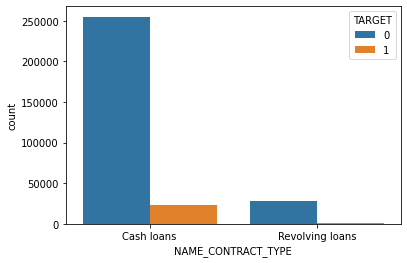

In [145]:
app_score_col_rmvd.groupby('NAME_CONTRACT_TYPE').size()
sns.countplot(app_score_col_rmvd,x='NAME_CONTRACT_TYPE',hue='TARGET')

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='PCT'>

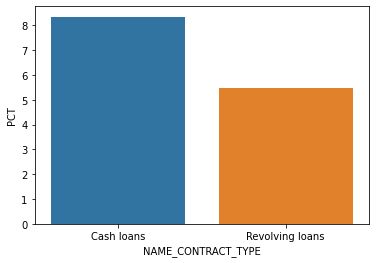

In [148]:

data_pct = app_score_col_rmvd[['NAME_CONTRACT_TYPE','TARGET']].groupby(['NAME_CONTRACT_TYPE'], as_index=False).mean().sort_values(by='TARGET',ascending=False)
data_pct['PCT'] = data_pct['TARGET']*100
sns.barplot(data=data_pct,x='NAME_CONTRACT_TYPE',y='PCT')

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='PCT'>

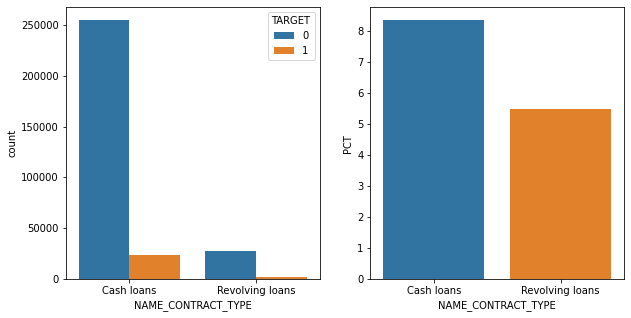

In [149]:

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(data=app_score_col_rmvd,x='NAME_CONTRACT_TYPE',hue='TARGET')

plt.subplot(1,2,2)
sns.barplot(data=data_pct,x='NAME_CONTRACT_TYPE',y='PCT')


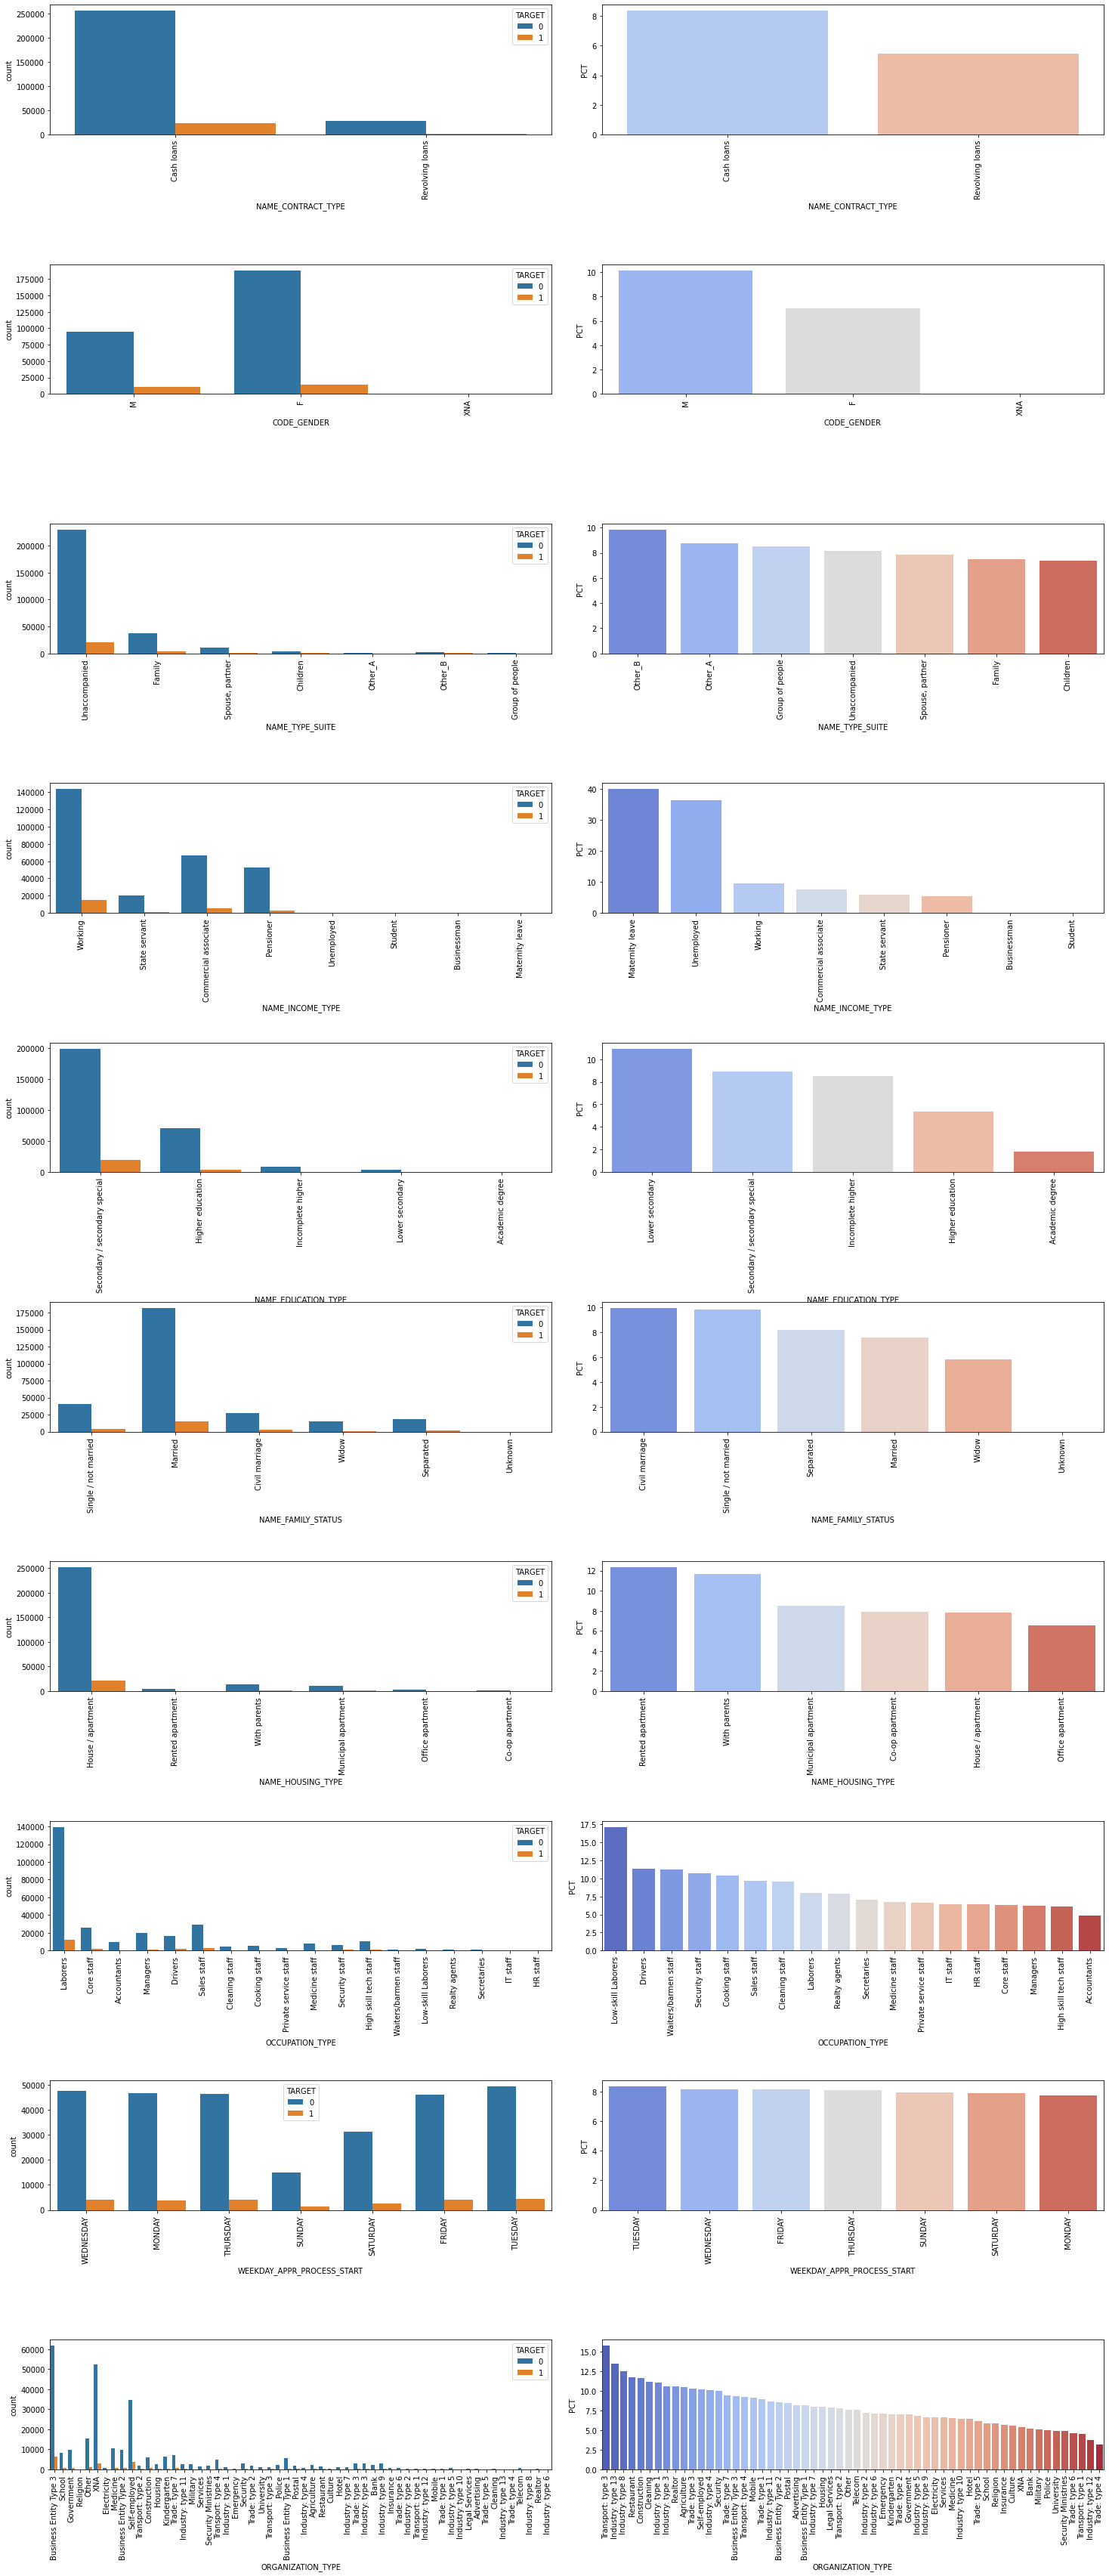

In [150]:
plt.figure(figsize=(25,60))


for i, var in enumerate(obj_var):

    data_pct = app_score_col_rmvd[[var,'TARGET']].groupby([var], as_index=False).mean().sort_values(by='TARGET',ascending=False)
    data_pct['PCT'] = data_pct['TARGET']*100


    plt.subplot(10,2,i+i+1)
    plt.subplots_adjust(wspace=0.1,hspace=1)
    sns.countplot(data=app_score_col_rmvd,x=var,hue='TARGET')
    plt.xticks(rotation=90)

    plt.subplot(10,2,i+i+2)
    sns.barplot(data=data_pct,x=var,y='PCT',palette='coolwarm')
    plt.xticks(rotation=90)

In [171]:

num_var = app_score_col_rmvd.select_dtypes(include=['float64','int64']).columns
num_cat_var = app_score_col_rmvd.select_dtypes(include=['float64','int64','category']).columns
len(num_var)

num_data = app_score_col_rmvd[num_var]
defaulters = num_data[num_data['TARGET']==1]
repayers = num_data[num_data['TARGET']==0]
repayers.head()


defaulters[['SK_ID_CURR','CNT_CHILDREN','AMT_INCOME_TOTAL']].corr()

defaulter_corr = defaulters.corr()
defaulter_corr_unstck = defaulter_corr.where(np.triu(np.ones(defaulter_corr.shape),k=1).astype(bool)).unstack().reset_index().rename(columns={'level_0':'var1','level_1':'var2',0:'corr'})
#defaulter_corr_unstck = defaulter_corr.where(np.triu(np.ones(defaulter_corr.shape),k=1).astype(np.bool)).unstack().reset_index().rename(columns={'level_0':'var1','level_1':'var2',0:'corr'})
defaulter_corr_unstck['corr'] = abs(defaulter_corr_unstck['corr'])
defaulter_corr_unstck.dropna(subset=['corr']).sort_values(by=['corr'],ascending=False).head(10)

repayers_corr = repayers.corr()
repayers_corr_unstck = repayers_corr.where(np.triu(np.ones(repayers_corr.shape),k=1).astype(bool)).unstack().reset_index().rename(columns={'level_0':'var1'
                                                                                                                         ,'level_1':'var2'
                                                                                                                         ,0:'corr'})
repayers_corr_unstck['corr'] = abs(repayers_corr_unstck['corr'])
repayers_corr_unstck.dropna(subset=['corr']).sort_values(by=['corr'],ascending=False).head(10)



,var1,var2,corr
814,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998508
202,AMT_GOODS_PRICE,AMT_CREDIT,0.987022
475,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950149
398,CNT_FAM_MEMBERS,CNT_CHILDREN,0.878571
611,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.861861
848,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,0.859332
713,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,0.830381
203,AMT_GOODS_PRICE,AMT_ANNUITY,0.776421
169,AMT_ANNUITY,AMT_CREDIT,0.771297
305,DAYS_EMPLOYED,DAYS_BIRTH,0.626114


c:\users\anand\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\users\anand\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\users\anand\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\users\anand\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

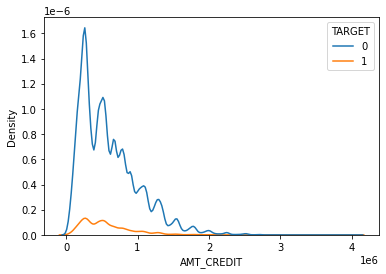

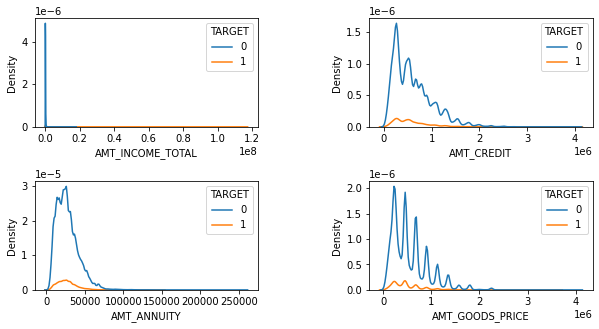

In [177]:
amt_var = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

sns.kdeplot(data=num_data,x='AMT_CREDIT',hue='TARGET')

plt.figure(figsize=(10,5))

for i, col in enumerate(amt_var):
    plt.subplot(2,2,i+1)
    sns.kdeplot(data=num_data,x=col,hue='TARGET')
    plt.subplots_adjust(wspace=0.5,hspace=0.5)

(307511, 33)

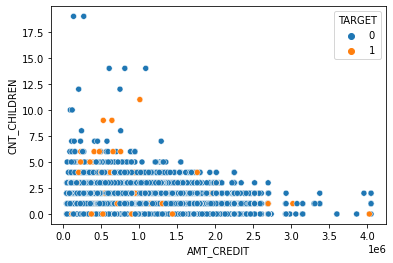

In [188]:

sns.scatterplot(data=num_data,x='AMT_CREDIT',y='CNT_CHILDREN',hue='TARGET')

amt_var = num_data[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','TARGET']]

sns.pairplot(data=amt_var,hue='TARGET')

# Conclution of Analysis

# # All the analysis

# most of the customers have taken cash loan
# customers who have taken cash loans are less likely to default
# 
# CODE_GENDER - 
# 
#     most of the loans have been taken by female
#     default rate for females are just ~7% which is safer and lesser than male
# 
# NAME_TYPE_SUITE - 
# 
#     unacompanied people had tanke most of the loans and the default rate is ~8.5% which is still okay
# 
# NAME_INCOME_TYPE - 
# 
#     the safest segments are working, commercial associates and pensioners
# 
# NAME_EDUCATION_TYPE - 
# 
#     Higher education is the safest segment to give the loan with a default rate of less than 5%
# 
# NAME_FAMILY_STATUS - 
# 
#     Married people are safe to target, default rate is 8%
# 
# 
# NAME_HOUSING_TYPE - 
# 
#     People having house/appartment are safe to give the loan with default rate of ~8%
# 
# OCCUPATION_TYPE - 
# 
#     Low-Skill Laboreres and drivers are highest defaulters
#     Accountants are less defaulters
#     Core staff, Managers and Laborers are safer to target with a default rate of <= 7.5 to 10%
# 
# ORGANIZATION_TYPE - 
# 
#     Transport type 3 highest defaulter
#     Others, Business Entity Type 3, Self Employed are good to go with default rate around 10 %
# 
# =======univariate numeric variables analysis========
# 
#     >> most of the loans were given for the goods price ranging between 0 to 1 ml
#     >> most of the loans were given for the credit amount of 0 to 1 ml
#     >> most of the customers are paying annuity of 0 to 50 K
#     >> mostly the customers have income between 0 to 1 ml
# 
# =============bivariate analysis==================
# 
#     >> AMT_CREDIT and AMT_GOODS_PRICE are linearly corelated, if the AMT_CREDIT increases the defaulters are decreasing
#     >> people having income less than or equals to 1 ml, are more like to take loans out of which who are taking loan of less than 1.5 million, coudl turn out to be defaulters. we can target income below 1 million and loan maount greater than 1.5 million
#     >> people having children 1 to less than 5 are safer to give the loan
#     >> People who can pay the annuity of 100K are more like to get the loan and that's upto less than 2ml (safer segment)
# 
# ============analysis on merged data==============
# 
#     >> for the repairing purpose customers had applied mostly prev. and the same puspose has most number of cancelations
#     >> most of the app. which were prev. either canceled or refused 80-90% of them are repayer in the current data
#     >> offers which were unused prev. now have maximum number of defaulters despite of having high income band customers

# # Final Conclusion/Insights

# Bank should target the customers
# 
#     >> having low income i.e. below 1 ml
#     >> working in Others, Business Entity Type 3, Self Employed  org. type
#     >> working as Accountants, Core staff, Managers and Laborers 
#     >> having house/appartment and are married and having children not more than 5
#     >> Highly educated
#     >> preferably female
# 
#     >> unacompanied people can be safer -  default rate is ~8.5%
# 
# Amount segment recommended -
# 
#     >> the credit amount should not be more than 1 ml
#     >> annuity can be made of 50K (depending on the eligibility)
#     >> income bracket could be below 1 ml
# 
#     >> 80-90% of the customer who were prev. canceled/refused, are repayers. Bank can do the analysis and can consider to give loan to these segments
# 
# 
# ====================precautions===============
# 
#     >> org. Transport type 3 should be avoided
#     >> Low-Skill Laboreres and drivers  should be avoided
#     >> offers prev. unused and high income customer should be avoided
# 


